In [1]:
import duckdb
import json
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import networkx as nx
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import umap
import seaborn as sns
from sklearn.cluster import DBSCAN

In [28]:
cursor = duckdb.connect()

In [29]:
sql = """\
select * from 'tether_dataset.parquet' where greatest(avg_cnt_in, avg_cnt_out) < 1
"""

In [30]:
df_full = cursor.sql(sql).df()
df = df_full[['avg_cnt_in', 'avg_cnt_out', 'stdev_cnt_in', 'stdev_cnt_out']]

In [31]:
cursor.close()

In [32]:
df.head()

,avg_cnt_in,avg_cnt_out,stdev_cnt_in,stdev_cnt_out
0,0.41,0.41,0.75,0.75
1,0.16,0.34,0.39,0.68
2,0.38,0.87,0.56,0.98
3,0.35,0.35,0.59,0.59
4,0.14,0.14,0.37,0.37


In [33]:
print(len(df))

33343


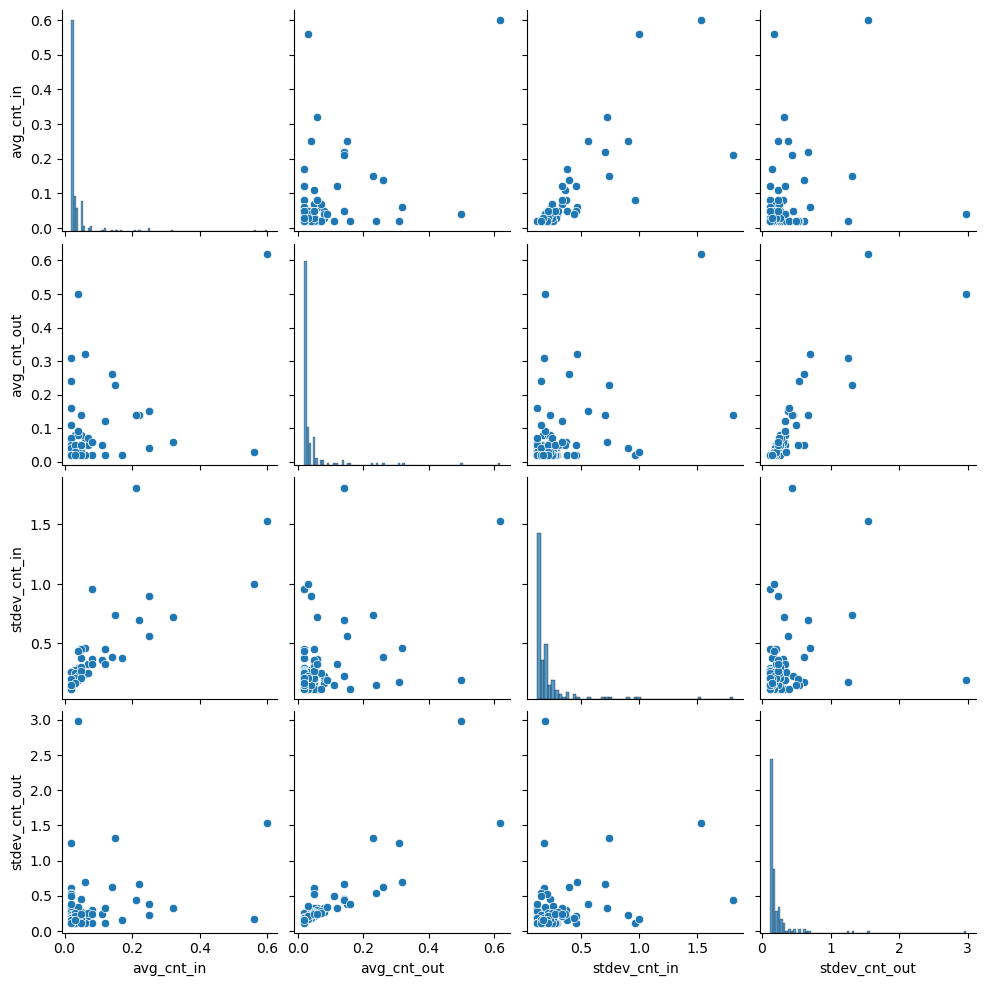

In [34]:
sns.pairplot(df.sample(200))

In [35]:
x = df.to_numpy()

In [36]:
filter_funct = umap.UMAP(n_neighbors=5, unique=True, random_state=42)

In [37]:
x_t = filter_funct.fit_transform(x)

/opt/conda/envs/polyanka/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


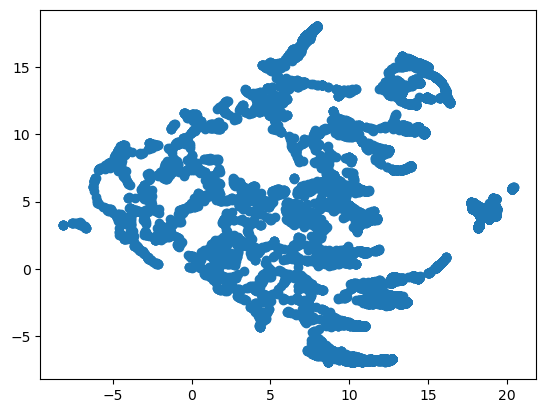

In [38]:
plt.scatter(
    x_t[:, 0],
    x_t[:, 1])

In [39]:
db = DBSCAN(eps=1, min_samples=10).fit(x_t)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 0


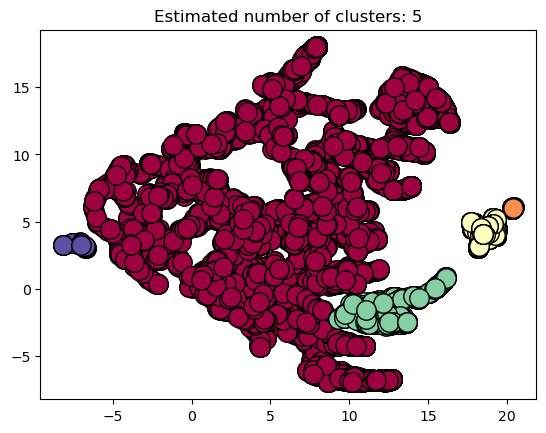

In [40]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = x_t[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = x_t[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

In [15]:
print(labels)

[ 0  0  0  0  1  0  0  0  0  2  0  3  3  4  0  3  0  1  2  0  2  2  0  3
  4  0  5  1  4  3  2  0  0  6  0  4  2  0  6  0  3  4  2  3  3  1  1  3
  3  3  1  3 -1  3  0 -1  3  3  0  0  0  1  0  4  0  4  0  0  3  4  0  2
  4  3  2  0  4  3  4  0  3  6  3  0  0  1  3  2  2  4  0  3  4  6  3  3
  4  3  2  4  0  6  0  6  4  2  0  3  1  0  3  3  4  0  0  3  0 -1  3  3
  1  0  1  3  5  6  3  5  5  5  0  0  5  6  3  5  5  5  5  5  5  3  5  3
  3  6  3  3  5  6  3  3  6  1  3  3  3  0  5  5  5  5  5  6  0  5  5  5
  6  5  5  3  5  5  0  0  5  5  0  5  1  3 -1  5  3  0  0  3  6  5  5  5
  5  5  5  6  6  6  0  2  1  0  4  0  2  0  6  0  2  0  4  0  6  0  2  0
  0  1  6  0  0  0  3  0  4  1  2  4  0  1  3  1  2  3  4  3  4  3  1  1
  2  3  1  6  3  3  3  3  3 -1  6  0  2  0  1  1  6  0  0  4  0  0  2  0
  0  3  5  3  1  1  1  1  0  1  1  4  5  4  3  3  0  3  4  5  1  4  3  3
  4 -1  3  0  0  4  4  3  0  3  3  5  3  3  0  3  3  0  3  3 -1  0  5  3
 -1  6  1  3  0  6  3  6 -1  0  3  0  1  5  5  3  3

In [16]:
df_full['label'] = labels

In [24]:
df_full.query('label == 6').head(20)

,adr,name,cnt_uniq_out,sum_out,cnt_uniq_in,sum_in,lifetime,avg_cnt_out,avg_cnt_in,stdev_cnt_out,stdev_cnt_in,adr_type,label
33,0x933597a323Eb81cAe705C5bC29985172fd5A3973,StargatePoolMigratable,512,1.016256e+13,177,1.093850e+13,467652,4.66,2.06,4.51,1.47,contract,6
38,0x1458770554b8918B970444d8b2c02A47F6dF99A7,UniswapV3Pool,61,9.095167e+10,33,8.795023e+10,464508,4.66,2.46,3.74,1.98,contract,6
81,0x1C727a55eA3c11B0ab7D3a361Fe0F3C47cE6de5d,None,579,1.031523e+12,115,7.968522e+11,468216,6.89,1.12,4.16,3.21,wallet,6
93,0x66D4104f99F6A3df367D9EC702cCDbd3c4C52cd1,None,63,1.229153e+11,179,1.835115e+11,466032,2.08,1.65,7.11,1.57,wallet,6
101,0x5c89724967D76a4f966b013140355789093F6c7D,None,341,2.470218e+12,198,2.848606e+12,468000,4.22,3.51,13.31,2.26,wallet,6
103,0x258494A21d9EA90FCBcB9E22BD57C6899dE0D995,None,207,2.108613e+12,198,2.561167e+12,465000,2.12,1.60,5.33,1.51,wallet,6
125,0xC2B4AC21eE19FEc0A9caD0Cd9eFddA1bb93Bf162,None,211,9.086783e+11,9,9.492826e+11,330336,4.78,0.28,4.21,0.63,wallet,6
133,0x9242ACc08fb7a16DD9201E805Df7aD215915022d,None,65,1.743362e+10,1,1.773821e+10,442512,1.39,0.05,3.67,0.21,wallet,6
145,0x2067Bfd291F040f44CCa88dCC75F3F86B49903d1,None,123,3.573665e+11,1,9.000000e+11,374124,1.02,0.02,4.56,0.18,wallet,6
149,0x79672062c5a45E3808D6B784129Cf3eCF59d4224,None,505,1.777464e+12,35,3.400340e+12,461256,4.12,0.45,19.92,0.93,wallet,6


In [27]:
cursor = duckdb.connect()
sql = """\
select * from 'tether_dataset.parquet' where greatest(avg_cnt_in, avg_cnt_out) < 1
"""
cursor.sql(sql).show(max_width=125)
cursor.close()

┌──────────────────────┬──────────────────────┬──────────────┬───┬───────────────┬──────────────┬──────────┐
│         adr          │         name         │ cnt_uniq_out │ … │ stdev_cnt_out │ stdev_cnt_in │ adr_type │
│       varchar        │       varchar        │    int32     │   │    double     │    double    │ varchar  │
├──────────────────────┼──────────────────────┼──────────────┼───┼───────────────┼──────────────┼──────────┤
│ 0x99a58482BD75cbab…  │ Vyper_contract       │           20 │ … │          0.75 │         0.75 │ contract │
│ 0xcE9874C42DcE7fff…  │ DMMPool              │            5 │ … │          0.68 │         0.39 │ contract │
│ 0xB55436E3f0E4a80b…  │ UniswapV3Pool        │           19 │ … │          0.98 │         0.56 │ contract │
│ 0xE397c4883ec89ed4…  │ AcrossFacetPacked    │            1 │ … │          0.59 │         0.59 │ contract │
│ 0xB770FDfE8b7F3930…  │                      │            9 │ … │          0.37 │         0.37 │ contract │
│ 0x7F76A06E8485bb5